**2.1.1: Setup**

Importing various required modules and the MNIST dataset. Initializing randomizer.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.datasets import MNIST
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import ToTensor
import statistics
import math
# Static random seed
np.random.seed(89)

# Need to convert data to Tensor, because the DataLoader iterator refuses to work with PIL image objects.
# Also experienced other trouble when having the PIL image
pil2tensor = lambda x: ToTensor()(x).squeeze()   # ToTensor return (64,1,28,28), the squeeze() call removes the 1 dimension

# Standard MNIST dataset (not binarized)
mnist_train_data = MNIST("./temp/", transform=pil2tensor, download=True, train=True)
mnist_test_data = MNIST("./temp/", transform=pil2tensor, download=True, train=False)

**2.1.2: Plot 8x8 random samples**

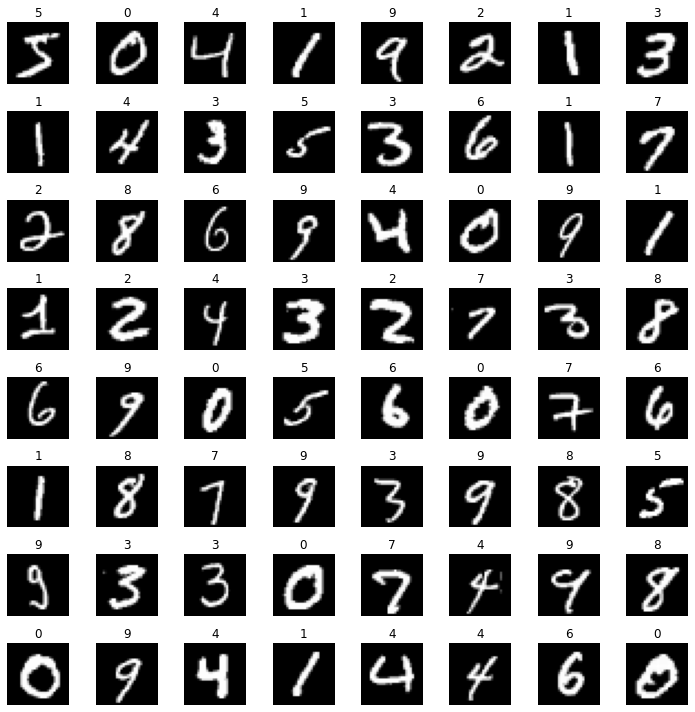

In [2]:
from torch.utils.data import DataLoader

mnist_train_loader = DataLoader(mnist_train_data, batch_size = 64)
images, labels = next(iter(mnist_train_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**2.1.3: Implement dynamic binarization**

Sampling binarized pixels using intensity as probability.

In [3]:
# Setup Bernoulli statistical sampling conversion from grey-scale to binary
from torchvision import transforms

# When indexing into 'binarized_mnist_xxx_data' we implicitly call '__getitem__', which
# normalizes MNIST data. Thus 'transform' gets values in the range [0,1].
binarized_mnist_train_data = MNIST("./temp/",
                                   download=True,
                                   train=True,
                                   transform=transforms.Compose([pil2tensor,
                                                                 transforms.Lambda(lambda x: torch.bernoulli(x))]))
binarized_mnist_test_data = MNIST("./temp/",
                                  download=True,
                                  train=False,
                                  transform=transforms.Compose([pil2tensor,
                                                                transforms.Lambda(lambda x: torch.bernoulli(x))]))

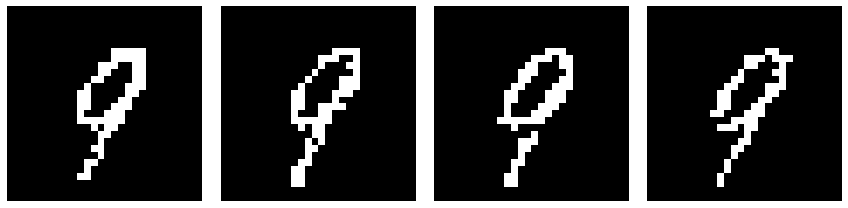

In [4]:
# Plot same image a couple of times to verify we are doing statistical sampling every time the image is drawn
fig, axs = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)
for ax in axs.flat:
    sample = binarized_mnist_train_data.__getitem__(22)[0]
    assert torch.max(sample) == 1.0
    assert torch.min(sample) == 0.0
    ax.imshow(sample, cmap='gray')
    ax.axis('off')
plt.tight_layout()

**2.1.4: Plot binarized MNIST samples**

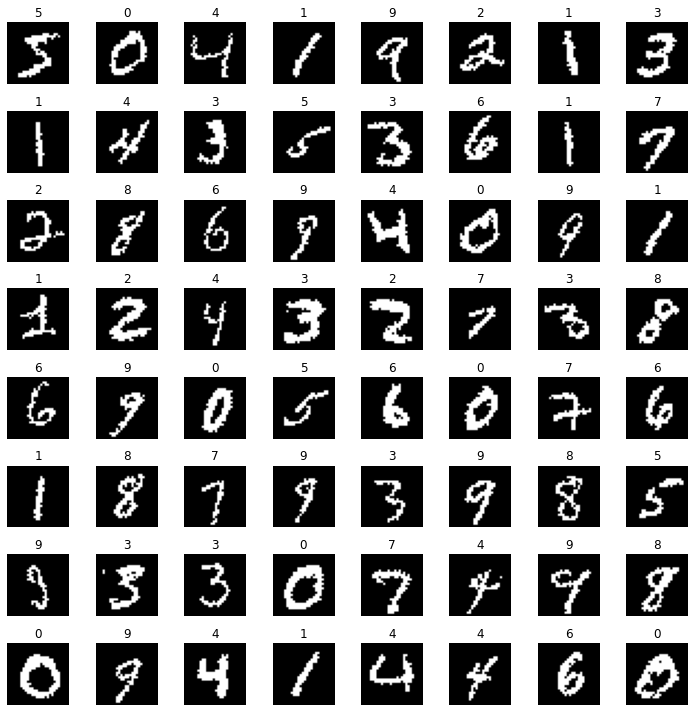

In [5]:
from torch.utils.data import DataLoader

binarized_mnist_train_loader = DataLoader(binarized_mnist_train_data, batch_size = 64)
images, labels = next(iter(binarized_mnist_train_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**2.2.1.1: VAE implementation**

In [6]:
# Implement reparameterized diagonal gaussian
from torch.distributions import Distribution

class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        from torch.distributions import Normal 
        return  Normal(loc=self.mu, scale=self.sigma).log_prob(z)

In [7]:
# Return sum of values in all dimenensions, except the first one, which is assumed to be batch
def reduce(x: Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

In [8]:
from typing import Dict, Any

from torch.distributions import Bernoulli

# Define hidden layer topology - list of sizes of hidden layers
encoder_dimensions = [512, 256, 128]
decoder_dimensions = [128, 256, 512]
apply_per_layer_batchnorm = False

# Implement VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # Core parameters
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        #self.prior_params = torch.zeros(torch.Size([1, 2*latent_features]))
        
        # Dynamically constructing the encoder network
        encoder_constructor = []
        encoder_constructor.append(nn.Linear(in_features=self.observation_features, out_features=encoder_dimensions[0]))
        encoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[0]))
        for i in range(len(encoder_dimensions)-1):
            encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[i], out_features=encoder_dimensions[i+1]))
            encoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[i+1]))
        encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[-1], out_features=2*self.latent_features))
        self.encoder = nn.Sequential(*encoder_constructor)

        # Dynamically constructing the decoder network
        decoder_constructor = []
        decoder_constructor.append(nn.Linear(in_features=self.latent_features, out_features=decoder_dimensions[0]))
        decoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[0]))
        for i in range(len(decoder_dimensions)-1):
            decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[i], out_features=decoder_dimensions[i+1]))
            decoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[i+1]))
        decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[-1], out_features=self.observation_features))
        self.decoder = nn.Sequential(*decoder_constructor)
    
    # Encode input into posterior distribution
    def encode(self, x: Tensor) -> Distribution:
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Decode latent variables into reconstruction
    def decode(self, z: Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
    
    # Get the prior distribution
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Sample from a provided distribution
    def sample(self, distribution: ReparameterizedDiagonalGaussian) -> Tensor:
        return distribution.rsample()
    
    # Compute the ELBO
    def elbo(self, prior: Distribution, posterior: Distribution, reconstruction: Distribution, x: Tensor, z: Tensor) -> float:
        tst = reconstruction.sample()
        x = x.view(x.size(0), -1)
        log_px = reduce(reconstruction.log_prob(x))
        log_pz = reduce(prior.log_prob(z))
        log_qz = reduce(posterior.log_prob(z))
        kl = log_qz - log_pz
        elbo = log_px - kl
        return elbo
    
    def forward(self, x: Tensor) -> Dict[str, Any]:
        # flatten the input
        x = x.view(x.size(0), -1)
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.encode(x)
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        # define the observation model p(x|z) = B(x | g(z))
        px = self.decode(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

In [9]:
# Instantiate a VAE
testVAE = VariationalAutoEncoder(sample.flatten().shape, 5)
print(testVAE.encoder)
print(testVAE.decoder)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=5, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
)


**2.2.1.2: Print samples from untrained VAE**

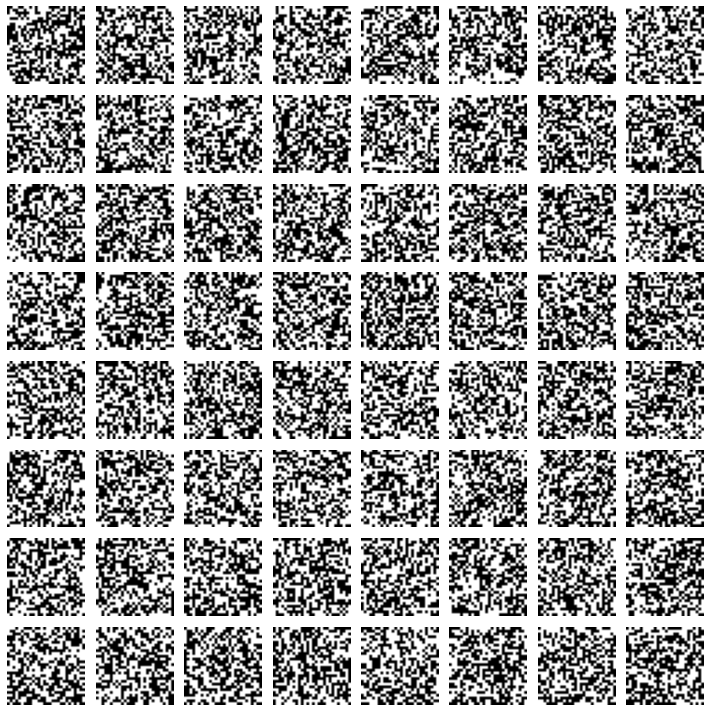

In [10]:
# Method 1: Decoding sample from prior
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

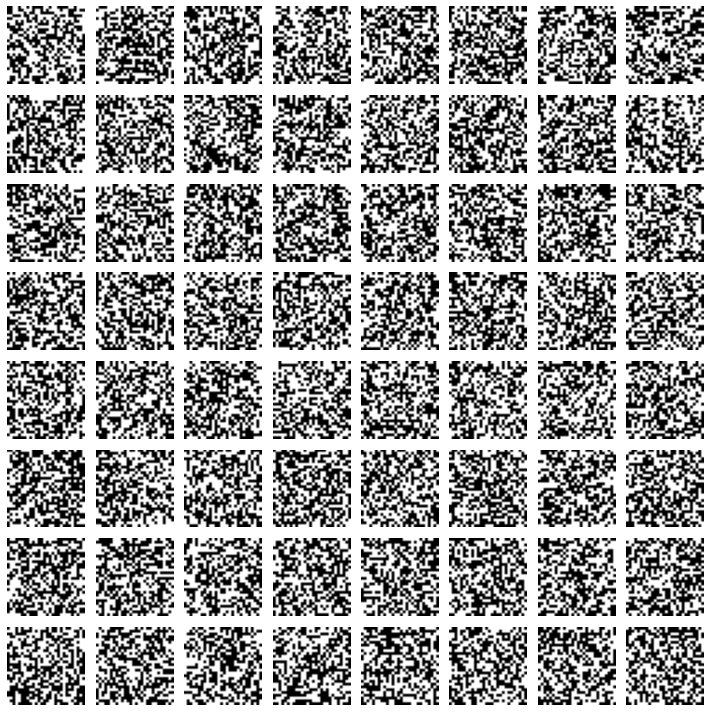

In [11]:
# Method 2: Reconstruction of input from binarized MNIST
a = random.choices(binarized_mnist_train_data,k=64)
b = [x[0] for x in a]
img = torch.stack(b)
sampled_decode_content = testVAE(img)['px'].sample().view(-1,28,28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

**2.2.1.3: Compute ELBO of 64 samples**

In [12]:
sample_cnt = 64
samples = np.zeros(shape=(sample_cnt, 784))
labels = np.zeros(shape=(sample_cnt, 1))
for i in range(sample_cnt):
    sample = random.choice(binarized_mnist_train_data)
    samples[i] = sample[0].view(1, -1).numpy()
    labels[i] = sample[1]

prior = testVAE.prior(sample_cnt)
samples_tensor = Tensor(samples)
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior) # Random sampling
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

# 'float64' required because 'stdev' chokes on 'float32' which is the default type when detaching from GPU
elbo_ary = elbo.detach().numpy().astype('float64')
elbo_stddev = statistics.stdev(elbo_ary)
elbo_mean = statistics.mean(elbo_ary)
print("ELBO on %d train data: %.1f +/-%.1f" % (sample_cnt, elbo_mean,elbo_stddev))

ELBO:  tensor([-543.6588, -545.1731, -544.3822, -543.3994, -543.1370, -543.1293,
        -544.6992, -543.8899, -543.2590, -544.2805, -543.1022, -545.5198,
        -543.6724, -544.6358, -544.0638, -545.2515, -543.4180, -544.0153,
        -544.4202, -544.3579, -544.2993, -545.1805, -542.9673, -544.7781,
        -543.7111, -543.7997, -543.7587, -543.5715, -544.5677, -543.6036,
        -543.7390, -543.2441, -544.5021, -544.4687, -543.3232, -544.1613,
        -543.0235, -543.8002, -543.7546, -543.2358, -543.3511, -543.7308,
        -544.2562, -543.5640, -543.8785, -545.3600, -544.6334, -543.8761,
        -543.7244, -543.1421, -543.7084, -543.4324, -543.9784, -543.5775,
        -544.5905, -543.7943, -543.0566, -543.5922, -543.5707, -543.2863,
        -543.2659, -543.4303, -543.4312, -543.3668], grad_fn=<SubBackward0>)


**2.2.2.1 and 2.2.2.2: Implementing train and test methods in training helper class**

In [13]:
from torch import optim

class VAE_Trainer:
    def __init__(self, network: VariationalAutoEncoder, train: DataLoader, test: DataLoader):
        self.VAE = network
        self.train_data = train
        self.test_data = test
        if torch.cuda.is_available():
            self.device = "cuda:0"
            network.cuda()
        else:
            self.device = "cpu"
            network.cpu()
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def train(self):
        self.VAE.train()
        for images, labels in self.train_data:
            images = images.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.VAE(images)
            loss = -self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            loss.backward()
            self.optimizer.step()
    
    def test(self):
        self.VAE.eval()
        losses = []
        i = 0
        for images, labels in self.test_data:
            images = images.to(self.device)
            outputs = self.VAE(images)
            elbos = self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).cpu().detach().numpy()
            losses = np.append(losses, elbos)
        loss = -np.mean(losses)
        print("Loss: ", loss)

**2.2.2.3: Training the network**

**ToDo:** Implement state saving

In [14]:
binarized_mnist_test_loader = DataLoader(binarized_mnist_test_data, batch_size = 64)

trainer = VAE_Trainer(testVAE, binarized_mnist_train_loader, binarized_mnist_test_loader)
epochs = 200

for i in range(epochs):
    print("Training epoch ", i)
    trainer.train()
    print("Testing epoch ", i)
    trainer.test()

Training epoch  0
Testing epoch  0
Loss:  168.56157126312254
Training epoch  1
Testing epoch  1
Loss:  144.03340409507751
Training epoch  2
Testing epoch  2
Loss:  134.96189310207367
Training epoch  3
Testing epoch  3
Loss:  133.90647932548524
Training epoch  4
Testing epoch  4
Loss:  130.81749196777344
Training epoch  5
Testing epoch  5
Loss:  129.23736712913512
Training epoch  6
Testing epoch  6
Loss:  128.63783482189177
Training epoch  7
Testing epoch  7
Loss:  124.04634771442413
Training epoch  8
Testing epoch  8
Loss:  121.4657151233673
Training epoch  9
Testing epoch  9
Loss:  120.27114271755218
Training epoch  10
Testing epoch  10
Loss:  119.97411240825653
Training epoch  11
Testing epoch  11
Loss:  119.08046483383178
Training epoch  12
Testing epoch  12
Loss:  117.8505510723114
Training epoch  13
Testing epoch  13
Loss:  118.16120624580384
Training epoch  14
Testing epoch  14
Loss:  116.76936116924286
Training epoch  15
Testing epoch  15
Loss:  117.03374010601044
Training epoch

Testing epoch  130
Loss:  113.84225129089356
Training epoch  131
Testing epoch  131
Loss:  113.91740249938965
Training epoch  132
Testing epoch  132
Loss:  112.86566640644074
Training epoch  133
Testing epoch  133
Loss:  114.8541180217743
Training epoch  134
Testing epoch  134
Loss:  113.60439495792389
Training epoch  135
Testing epoch  135
Loss:  113.9999672876358
Training epoch  136
Testing epoch  136
Loss:  113.4781307044983
Training epoch  137
Testing epoch  137
Loss:  112.31424496116638
Training epoch  138
Testing epoch  138
Loss:  115.23842355518342
Training epoch  139
Testing epoch  139
Loss:  113.11768161582947
Training epoch  140
Testing epoch  140
Loss:  113.00846567287445
Training epoch  141
Testing epoch  141
Loss:  112.97866693992614
Training epoch  142
Testing epoch  142
Loss:  112.34056966705322
Training epoch  143
Testing epoch  143
Loss:  113.17945691375732
Training epoch  144
Testing epoch  144
Loss:  112.65235970916748
Training epoch  145
Testing epoch  145
Loss:  11

**2.2.2.4: Generating samples from trained model**

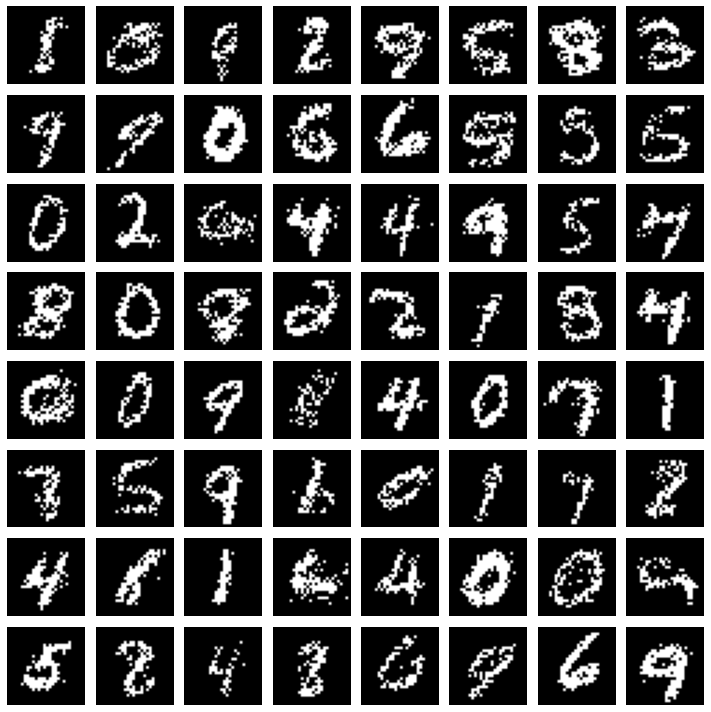

In [15]:
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

In [16]:
sample_cnt = binarized_mnist_test_data.data.shape[0]
#sample_cnt = 100
samples_tensor = torch.empty(sample_cnt,28,28)
for idx in range(samples_tensor.shape[0]):
    samples_tensor[idx] = binarized_mnist_test_data[idx][0]

prior = testVAE.prior(sample_cnt)
samples_tensor = samples_tensor.view(sample_cnt,-1)
samples_tensor.shape
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior)
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

# 'float64' required because 'stdev' chokes on 'float32' which is the default type when detaching from GPU
elbo_ary = elbo.detach().numpy().astype('float64')
elbo_stddev = statistics.stdev(elbo_ary)
elbo_mean = statistics.mean(elbo_ary)
print("ELBO on %d test data: %.1f +/-%.1f" % (sample_cnt, elbo_mean,elbo_stddev))

ELBO:  tensor([-136.3773, -103.0528, -126.2350,  -34.3827, -124.0197,  -84.5350,
         -75.8755, -125.0605,  -96.1175,  -83.5513,  -97.1028, -111.2609,
         -96.2052,  -50.0445,  -92.8681,  -80.6755, -113.1637,  -99.1346,
        -139.5090, -108.5829, -130.4552, -202.2354, -118.8283,  -68.0293,
         -82.8024,  -97.6256,  -53.2694,  -90.4243, -168.7541,  -45.7475,
        -133.4456, -108.4420,  -94.7978, -134.1457,  -64.6586, -117.6108,
        -190.0463,  -79.3550, -140.5785, -139.8687, -107.5805, -116.7631,
         -76.4994,  -55.6510, -148.6254, -117.9454,  -53.5959, -114.0288,
        -119.5462, -169.9166, -138.0895, -113.2031,  -93.9317,  -54.6543,
         -44.8702,  -96.2607,  -77.9002, -108.7049,  -97.8204,  -46.6467,
         -90.1472,  -80.3585, -113.2186,  -75.5794], grad_fn=<SubBackward0>)


**2.3.1: Extracting 10 samples per class for classification training**

**ToDo:** Consider more elegant solution for classification_sampler

In [41]:
from torch.utils.data.sampler import SubsetRandomSampler
import functools

def classification_sampler(labels):
    indices = []
    for i in range(10):
        #(tmp_indices,) = np.where(functools.reduce(lambda x, y: x | y, [labels.numpy() == i]))
        tmp_indices = np.where(labels.numpy() == i)[0]
        indices.append(random.choices(tmp_indices, k=10))
    indices = torch.Tensor(indices)
    indices = indices.view(1, -1).squeeze().int()
    return SubsetRandomSampler(indices)
    
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=25,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))
# Accuracy of Test Accuracy estimates based on batch_size
#  10k: baseline
# 2000: 0.5% 0.9% 1.6%
# 5000: 0.2% 0.9% 1.2%
# Adding 2.5 sec by using all test data instead of just 1000. Worth the price.
classification_loader_test = DataLoader(binarized_mnist_test_data, shuffle=True, batch_size=10000)

tensor([1, 5, 7, 8, 1, 6, 1, 7, 1, 2, 6, 9, 5, 9, 4, 3, 5, 9, 9, 6, 6, 1, 4, 0,
        0])
tensor([0, 2, 0, 4, 6, 1, 0, 7, 0, 4, 9, 2, 7, 2, 3, 2, 3, 2, 4, 7, 2, 8, 3, 2,
        9])
tensor([3, 5, 3, 6, 7, 8, 5, 9, 9, 4, 6, 4, 1, 2, 3, 4, 9, 3, 5, 8, 4, 3, 7, 4,
        5])
tensor([7, 7, 5, 1, 7, 8, 8, 6, 6, 0, 8, 0, 5, 3, 2, 8, 8, 9, 8, 1, 5, 1, 0, 6,
        0])


In [ ]:
# visual check that the same 100 pictures are printed, and only permutated. Evaluate this cell a couple of times.
for images, labels in classification_loader:
    fig, axs = plt.subplots(1, 25, figsize=(20, 25), squeeze=False)
    for i,ax in enumerate(axs.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off') 
    plt.tight_layout()

**2.3.2: Training classifier on latent representation**

In [111]:
# Define a classification model

class LatentClassifier(nn.Module):
    def __init__(self, latent_features:int) -> None:
        super(LatentClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(latent_features*2),    # MAGIC! raises accurcay from 50% to 75%
                                   nn.Linear(in_features=latent_features*2, out_features=10), 
                                   nn.Sigmoid(),  # Initial network used ReLU in output layer, however this was prone to give
                                                  # dead outputs, eg. classifier would often train so some classes would 
                                                  # never be guessed
                                   nn.Dropout(p=0.5)        # raises accuracy from 75% to 83%
                                  )
        
    def forward(self, x) -> Tensor:
        x = self.model(x)
        return x

In [ ]:
# This class builds a M1 classifier. Output is logits tensor. UNDER CONSTRUCTION.
class M1Classifier(nn.Module):
    def __init__(self, VAE: nn.Module, LatentClassifier: nn.Module) -> None:
        super(M1Classifier, self).__init__()
        self.VAE = VAE
        self.LatentClassifier = LatentClassifier
        

In [ ]:
def do_test_eval(cnt, epochs, num_of_evals):
    # Used for doing occasional print of test evaluation data.
    # Return true 'num_of_evals' times when running range(epochs) training
    # Will also trigger at start and end
    modulu = math.ceil(epochs/(num_of_evals-1))
    return cnt==0 or cnt==epochs-1 or cnt % modulu == modulu-1

In [ ]:
def confuse_matrix_update(predictions, labels, confusion_matrix):
    # Update 'confusion_matrix' according the the prodictions/labels vectors.
    # Confusion_matrix rows are actual labels, and columns predictions. E.g. row 0 
    # tells how the classifier predicted '0', (0,0) represents correct predictions, 
    # (0,1) is how many times a '0' was classified as a '1'
    for pre, lbl in zip(predictions, labels):
        confusion_matrix[lbl,pre] += 1
def confuse_matrix_accuracy(cm):
    return cm.trace()/cm.sum()
if False:
    cm = np.zeros((10,10))
    pred=torch.tensor([2,9,8,6])
    lab =torch.tensor([2,9,8,4])
    confuse_matrix_update(pred,lab,cm)
    confuse_matrix_update(pred,lab,cm)
    print(cm, confuse_matrix_accuracy(cm))

In [121]:
%%time
testVAE.eval()

testLC = LatentClassifier(5)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(testLC.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(testLC.parameters(), lr=0.005)


epochs = 200
images_test, labels_test = next(iter(classification_loader_test))

for epoch in range(epochs):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testLC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        outputs = testVAE(images_test)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Accuracy:  0.09
Accuracy:  0.07
Accuracy:  0.09
Accuracy:  0.08
Accuracy:  0.08
Accuracy:  0.08
Accuracy:  0.09
Accuracy:  0.13
Accuracy:  0.12
Accuracy:  0.14
Accuracy:  0.11
Accuracy:  0.14
Accuracy:  0.15
Accuracy:  0.16
Accuracy:  0.14
Accuracy:  0.14
Accuracy:  0.15
Accuracy:  0.17
Accuracy:  0.15
Accuracy:  0.17
Accuracy:  0.15
Accuracy:  0.16
Accuracy:  0.16
Accuracy:  0.17
Accuracy:  0.17
Accuracy:  0.18
Accuracy:  0.17
Accuracy:  0.2
Accuracy:  0.2
Accuracy:  0.19
Accuracy:  0.23
Accuracy:  0.21
Accuracy:  0.24
Accuracy:  0.25
Accuracy:  0.28
Accuracy:  0.28
Accuracy:  0.31
Accuracy:  0.29
Accuracy:  0.29
Accuracy:  0.32
Accuracy:  0.3
Accuracy:  0.32
Accuracy:  0.33
Accuracy:  0.34
Accuracy:  0.37
Accuracy:  0.35
Accuracy:  0.35
Accuracy:  0.35
Accuracy:  0.35
Accuracy:  0.37
Accuracy:  0.38
Accuracy:  0.38
Accuracy:  0.4
Accuracy:  0.37
Accuracy:  0.37
Accuracy:  0.39
Accuracy:  0.4
Accuracy:  0.37
Accuracy:  0.4
Accuracy:  0.39
Accuracy:  0.39
Accuracy:  0.39
Accuracy:  0.3

In [ ]:
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=100,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))
optimizer = optim.Adam(testLC.parameters(), lr=0.0005)
for epoch in range(epochs):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testLC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        outputs = testVAE(images_test)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Cells notes:
Initial results showed large accuracy variation, varying from 0.40 to 0.73 accuracy. Confusion matrix revealed that some numbers were never chosen. E.g. below where classifier never outputs a '9' classification.
<code>
[[464   0  12   5   0   2   9   0   0   0]
 [  0 489   2   9   3   1  39  22   0   0]
 [  6   1 484   4   5   0   1   7  10   0]
 [  2   1  13 361   3  15   7   8  86   0]
 [  1   0   7   3 418   4   3  43   4   0]
 [ 17   1   4  17   4 389  15   8   4   0]
 [ 80   3  49   0   1  24 327   0   0   0]
 [  0   6   9   5   8   1   7 468   1   0]
 [  4   1  95  29  14  17   7  10 328   0]
 [  0   1  33  65 100   0   2 175 117   0]]
</code>

**2.3.3: Classifying MNIST using simple FFNN**

In [126]:
# Define a classification model

class SimpleClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super(SimpleClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(input_shape),
                                   nn.Linear(in_features=input_shape, out_features=10),
                                   nn.Dropout(p=0.5),   # raises from 66% to 70%
                                   nn.Sigmoid(),
                                  )
        
    def forward(self, x) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [127]:
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=100,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))

testSC = SimpleClassifier(784)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testSC.parameters(), lr=0.001)


epochs = 200
for epoch in range(epochs):
    # Training
    testSC.train()
    for images, labels in classification_loader:
        optimizer.zero_grad()
        classifications = testSC(images)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testSC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        classifications = testSC(images_test)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Accuracy:  0.1
Accuracy:  0.08
Accuracy:  0.1
Accuracy:  0.13
Accuracy:  0.15
Accuracy:  0.12
Accuracy:  0.15
Accuracy:  0.17
Accuracy:  0.21
Accuracy:  0.22
Accuracy:  0.25
Accuracy:  0.23
Accuracy:  0.25
Accuracy:  0.3
Accuracy:  0.24
Accuracy:  0.23
Accuracy:  0.26
Accuracy:  0.28
Accuracy:  0.32
Accuracy:  0.32
Accuracy:  0.32
Accuracy:  0.35
Accuracy:  0.31
Accuracy:  0.31
Accuracy:  0.38
Accuracy:  0.38
Accuracy:  0.41
Accuracy:  0.37
Accuracy:  0.4
Accuracy:  0.4
Accuracy:  0.4
Accuracy:  0.44
Accuracy:  0.43
Accuracy:  0.46
Accuracy:  0.41
Accuracy:  0.45
Accuracy:  0.48
Accuracy:  0.47
Accuracy:  0.47
Accuracy:  0.46
Accuracy:  0.47
Accuracy:  0.48
Accuracy:  0.5
Accuracy:  0.49
Accuracy:  0.52
Accuracy:  0.56
Accuracy:  0.58
Accuracy:  0.52
Accuracy:  0.59
Accuracy:  0.57
Accuracy:  0.61
Accuracy:  0.59
Accuracy:  0.6
Accuracy:  0.62
Accuracy:  0.64
Accuracy:  0.61
Accuracy:  0.57
Accuracy:  0.61
Accuracy:  0.64
Accuracy:  0.63
Accuracy:  0.63
Accuracy:  0.62
Accuracy:  0.65


Notes: training results are noise, rerunning training can give from 64% to 69%. Thus at least 3 restarts must be done to determine is a change was beneficial. With only single-layer FFNN I have difficulty getting above 69%. The dropout layer on the output improves results from 65% to 69%. This is surprising for me, because in the output layer each node is necessary, because it is needed to identify one digit.